In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Raw Data Loading
df = pd.read_csv('../data/ozone.csv')
training_data = df[['Temp', 'Ozone']]

# 결측치 처리 (결측치 제거)
training_data = training_data.dropna(how='any')

# 이상치 처리 (이상치 제거)
# z-scroe 이용
zscore_threshold = 1.8

# temp 확인
# ~는 역 연산
tmp = ~(np.abs(stats.zscore(training_data['Temp'])) > zscore_threshold)
training_data = training_data.loc[tmp]

# Ozone 확인
tmp = ~(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)
training_data = training_data.loc[tmp]

# Min-Max Scaler를 이용한 정규화
# Min-Max Scaler라고 불리는 객체 생성
# 이 객체를 2개로 만듬 (Temp, Ozone)
scaler_x = MinMaxScaler()
scaler_t = MinMaxScaler()

# fit()에 2차원 형태의 데이터로 넘겨줘야 한다
scaler_x.fit(training_data['Temp'].values.reshape(-1,1))
scaler_t.fit(training_data['Ozone'].values.reshape(-1,1))
print(scaler_x.n_samples_seen_, scaler_x.feature_range,
      scaler_x.data_max_, scaler_x.data_min_)
training_data['Temp'] = scaler_x.transform(training_data['Temp'].values.reshape(-1,1))
training_data['Ozone'] = scaler_t.transform(training_data['Ozone'].values.reshape(-1,1))
display(training_data)

103 (0, 1) [94.] [61.]


,Temp,Ozone
0,0.181818,0.397849
1,0.333333,0.344086
2,0.393939,0.086022
3,0.030303,0.150538
5,0.151515,0.258065
...,...,...
147,0.060606,0.107527
148,0.272727,0.279570
150,0.424242,0.107527
151,0.454545,0.150538


In [4]:
# Training Data Set
x_data = training_data['Temp'].values.reshape(-1,1)
t_data = training_data['Ozone'].values.reshape(-1,1)

# 장치 확인
tf.debugging.set_log_device_placement(True)

# X, T
X = tf.placeholder(shape=[None,1], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

# W & b
W = tf.Variable(tf.random.normal([1,1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

# Hypothesis
H = tf.matmul(X, W) + b

# loss function
loss = tf.reduce_mean(tf.square(H - T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# session, 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:06:00.0, compute capability: 6.1



In [10]:
# learning
for step in range(300000):
    _,W_val,b_val,loss_Val = sess.run([train,W,b,loss], 
                                      feed_dict={X : x_data, T : t_data})
    
    if step % 30000 == 0:
        print('W : {}, b : {}, loss : {}'.format(W_val,b_val,loss_Val))

W : [[0.75973564]], b : [-0.02952323], loss : 0.03040917217731476
W : [[0.7691569]], b : [-0.03453021], loss : 0.030370797961950302
W : [[0.77584887]], b : [-0.03815271], loss : 0.030350729823112488
W : [[0.78087306]], b : [-0.04083083], loss : 0.030339688062667847
W : [[0.78444934]], b : [-0.04268894], loss : 0.03033391945064068
W : [[0.7870307]], b : [-0.04414573], loss : 0.030330771580338478
W : [[0.78881884]], b : [-0.04505163], loss : 0.030329158529639244
W : [[0.790607]], b : [-0.04595754], loss : 0.030327975749969482
W : [[0.7919033]], b : [-0.04670073], loss : 0.030327361077070236
W : [[0.79228187]], b : [-0.04694228], loss : 0.030327225103974342


- sklearn

In [15]:
training_data = df[['Temp', 'Ozone']]
training_data = training_data.dropna(how='any')

# 이상치 처리 (이상치 제거)
# z-scroe 이용
zscore_threshold = 1.8

# temp 확인
# ~는 역 연산
tmp = ~(np.abs(stats.zscore(training_data['Temp'])) > zscore_threshold)
training_data = training_data.loc[tmp]

# Ozone 확인
tmp = ~(np.abs(stats.zscore(training_data['Ozone'])) > zscore_threshold)
training_data = training_data.loc[tmp]



model = linear_model.LinearRegression()
model.fit(training_data['Temp'].values.reshape(-1,1), 
          training_data['Ozone'].values.reshape(-1,1))

print('W : {}, b : {}'.format(model.coef_, model.intercept_))

W : [[2.23956713]], b : [-137.09451328]


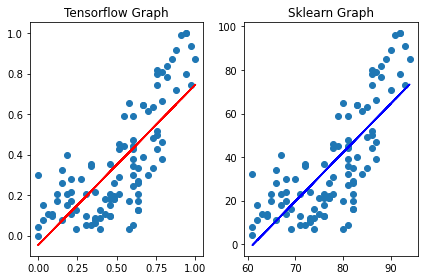

In [16]:
# Graph로 비교

fig = plt.figure()
fig_tensorflow = fig.add_subplot(1,2,1)
fig_sklearn = fig.add_subplot(1,2,2)

fig_tensorflow.set_title('Tensorflow Graph')
fig_sklearn.set_title('Sklearn Graph')

fig_tensorflow.scatter(x_data, t_data)
fig_tensorflow.plot(x_data, x_data*W_val.ravel() + b_val.ravel(), color='r')

fig_sklearn.scatter(training_data['Temp'].values.reshape(-1,1), 
                    training_data['Ozone'].values.reshape(-1,1))
fig_sklearn.plot(training_data['Temp'].values.reshape(-1,1), 
                 training_data['Temp'].values.reshape(-1,1)*model.coef_ + model.intercept_, color='b')

fig.tight_layout()

In [18]:
# prediction
# Temp가 62일때 Ozone은?

# sklearn
skleran_result = model.predict([[62]])
print('sklearn : {}'.format(skleran_result))

predict_data = np.array([[62]])
scaled_predict_data = scaler_x.transform(predict_data)

# tensorflow
tensorflow_result = sess.run(H, feed_dict={X : scaled_predict_data})

# 정규화된 값 다시 원래대로 돌리기
tensorflow_result = scaler_t.inverse_transform(tensorflow_result)

print('tensorflow : {}'.format(tensorflow_result))

sklearn : [[1.75864872]]
tensorflow : [[1.8616735]]


# Mutiple Linear Regression
---
- 온도, 태양광 세기, 바람 세기를 이용하여 Ozone량을 예측

In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf

from scipy import stats
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler

In [21]:
# Raw Data Loading
df = pd.read_csv('../data/ozone.csv')
training_data = df[['Temp', 'Wind', 'Solar.R', 'Ozone']]
print(training_data.shape)

# 결측치 처리 (결측치 제거)
training_data = training_data.dropna(how='any')
print(training_data.shape)

# 이상치 처리 
zscore_threshold = 1.8

for col in training_data.columns:
    tmp = ~(np.abs(stats.zscore(training_data[col])) > zscore_threshold)
    training_data = training_data.loc[tmp]

print(training_data.shape)

# 정규화
scaler_x = MinMaxScaler()
scaler_t = MinMaxScaler()

scaler_x.fit(training_data[['Temp', 'Wind', 'Solar.R']].values)
scaler_t.fit(training_data['Ozone'].values.reshape(-1,1))

training_data_x = scaler_x.transform(training_data[['Temp', 'Wind', 'Solar.R']].values)
training_data_t = scaler_t.transform(training_data['Ozone'].values.reshape(-1,1))

(153, 4)
(111, 4)
(86, 4)


- tensorflow

In [22]:
# X, T
X = tf.placeholder(shape=[None,3], dtype=tf.float32)
T = tf.placeholder(shape=[None,1], dtype=tf.float32)

# W & b
W = tf.Variable(tf.random.normal([3,1]), name='weight')
b = tf.Variable(tf.random.normal([1]), name='bias')

# Hypothesis
H = tf.matmul(X, W) + b

# loss function
loss = tf.reduce_mean(tf.square(H - T))

# train
train = tf.train.GradientDescentOptimizer(learning_rate=1e-4).minimize(loss)

# session, 초기화
sess = tf.Session()
sess.run(tf.global_variables_initializer())

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:06:00.0, compute capability: 6.1



In [23]:
# learning
for step in range(300000):
    _,W_val,b_val,loss_Val = sess.run([train,W,b,loss], 
                                      feed_dict={X : training_data_x, 
                                                 T : training_data_t})
    
    if step % 30000 == 0:
        print('W : {}, b : {}, loss : {}'.format(W_val,b_val,loss_Val))

W : [[ 0.17529766]
 [ 1.2674184 ]
 [-1.3677815 ]], b : [-1.2737067], loss : 3.2426156997680664
W : [[ 0.89273316]
 [ 1.0522438 ]
 [-0.50205886]], b : [-0.34906504], loss : 0.17395035922527313
W : [[ 0.987606  ]
 [ 0.62898636]
 [-0.2693085 ]], b : [-0.32501897], loss : 0.09154388308525085
W : [[ 1.0139637 ]
 [ 0.3547525 ]
 [-0.11110581]], b : [-0.29471207], loss : 0.05705389380455017
W : [[ 1.0056093 ]
 [ 0.17300667]
 [-0.00403198]], b : [-0.26196474], loss : 0.041633058339357376
W : [[0.9813847 ]
 [0.04945968]
 [0.06802788]], b : [-0.22927274], loss : 0.03417971357703209
W : [[ 0.95144784]
 [-0.03684982]
 [ 0.11614314]], b : [-0.19806832], loss : 0.03026585467159748
W : [[ 0.9210495 ]
 [-0.09889071]
 [ 0.14784466]], b : [-0.16923913], loss : 0.028042644262313843
W : [[ 0.8922833 ]
 [-0.14468585]
 [ 0.16849186]], b : [-0.14289524], loss : 0.026685332879424095
W : [[ 0.8663821 ]
 [-0.1794173 ]
 [ 0.18158618]], b : [-0.11930069], loss : 0.025811700150370598


- sklearn

In [24]:
# sklearn은 정규화를 알아서 하기 때문에 
# 입력 데이터에 대한 정규화를 진행하지 않고 넣는다

model = linear_model.LinearRegression()
model.fit(training_data[['Temp', 'Wind', 'Solar.R']].values, 
          training_data['Ozone'].values.reshape(-1,1))

print('W : {}, b : {}'.format(model.coef_, model.intercept_))

W : [[ 1.9400749  -2.7453281   0.05651878]], b : [-97.42698439]


In [25]:
# prediction
# sklearn
skleran_result = model.predict([[80,10,150]])
print('sklearn : {}'.format(skleran_result))


# tensorflow
# 온도 바람 태양광세기 > [80,10,150]
# 예측할때 정규화된 데이터를 사용해서 예측할때도 정규화된 데이터를 사용해야함

predict_data = np.array([[80,10,150]])
scaled_predict_data = scaler_x.transform(predict_data)

tensorflow_result = sess.run(H, feed_dict={X : scaled_predict_data})

# 예측된 값도 정규화된 값이니 이를 원래대로 돌려야함 
tensorflow_result = scaler_t.inverse_transform(tensorflow_result)
print('tensorflow : {}'.format(tensorflow_result))

sklearn : [[38.8035437]]
tensorflow : [[39.19742]]
